### Add the scripts to the notebooks path

In [1]:
import os, sys

current_dir = os.getcwd()
print(current_dir)

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

scripts_path = os.path.join(parent_dir, 'scripts')

# Insert the path to the parent directory
sys.path.insert(0, parent_dir)

# Insert the path to the Scripts directory
sys.path.insert(0, scripts_path)

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..')))

d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\notebooks


### Import Statements

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_theme()

### Load the Data

In [4]:
# define path to the csv files
COUNTRY_IP_DATA = "../data/IpAddress_to_Country.csv"
FRAUD_DATA = "../data/Fraud_Data.csv"
CREDIT_DATA = "../data/creditcard.csv"

# load the data into pandas dataframes
country_ip_mapping = pd.read_csv(COUNTRY_IP_DATA)
fraud_data = pd.read_csv(FRAUD_DATA)
credit_data = pd.read_csv(CREDIT_DATA)

### Preprocess data

In [5]:
from scripts.feature_engineering import FeatureEngineering

1) First pass the data through the feature egineering pipeline. It contains the following processes.

merege ip and fraud data -> calculate transaction velocity and frequency -> break down date features -> handle missing values

In [6]:
data = FeatureEngineering.feature_enginering_pipeline(data=fraud_data, ip_mapping=country_ip_mapping)

2. Split the data into training and testing sets

In [7]:
from sklearn.model_selection import train_test_split
from scripts.utils import load_pickle, pickle_object

In [8]:
# the root path where to export/load pickeled objects from
EXPORT_PATH_ROOT = "../feature_store" 

First for the credit card data

In [9]:
# define features
credit_card_features = [column for column in credit_data.columns if column not in ["Class"]]

# define target 
credit_card_target = "Class"

# save the feature into pickle file
feature_save_path = os.path.join(EXPORT_PATH_ROOT, 'credit_features.pkl')
pickle_object(file_path=feature_save_path, object=credit_card_features)

# save the target into a pickle file
target_save_path = os.path.join(EXPORT_PATH_ROOT, 'credit_target.pkl')
pickle_object(file_path=target_save_path, object=credit_card_target)

In [10]:
# obtain the features and targets
credit_X = credit_data[credit_card_features]
credit_y = credit_data[credit_card_target]

# split them into training and testing features
credit_train, credit_test, credit_y_train, credit_y_test = train_test_split(credit_X, credit_y, test_size=0.3, random_state=7)

Now for the fraud data

In [11]:
# define features
fraud_features = [column for column in data.columns if column not in ["class", "user_id", "device_id"]]

# define targets
fraud_targets = "class"

In [12]:
# obtain the features and targets
fraud_X = data[fraud_features]
fraud_y = data[fraud_targets]

# split them into training and testing features
fraud_train, fraud_test, fraud_y_train, fraud_y_test = train_test_split(fraud_X, fraud_y, test_size=0.3, random_state=7)

3. Normalize the numerical features

In [13]:
# the root path to store scalers and numerical encoders in
ENCODERS_PATH_ROOT = "../scalers"

First normalize the credit  scoring numerical features

In [14]:
# normalize the numerical features in the credit card data using the training data and save the scaler to be used during inference
credit_train, credit_numerical_scaler = FeatureEngineering.normalize_numerical_features(data=credit_train)
credit_test = credit_numerical_scaler.transform(X=credit_test)

Now normalize the fraud numerical features

In [15]:
# normalize the numerical features in the fraud data using training data and save the scaler to be used during inference
fraud_train_numeric_scaled, fraud_numerical_scaler = FeatureEngineering.normalize_numerical_features(data=fraud_train)
scaled_columns = fraud_numerical_scaler.get_feature_names_out()
fraud_test_numeric_scaled = fraud_numerical_scaler.transform(X=fraud_test[scaled_columns])

# replace the numerical columns with the scaled ones
fraud_train[scaled_columns] = fraud_train_numeric_scaled[scaled_columns]
fraud_test[scaled_columns] = fraud_test_numeric_scaled

4. Now encode the categorical features

In [16]:
from scripts.utils import use_label_encoder

The credit data is skipped because all of its values are numerical data. So no need to encode it. 
Only the fraud data is going to have to categorical columns to be encoded

In [17]:
# encode categorical features using data from training, obtain the encoders for each categorical columns
fraud_train, categorical_encoder = FeatureEngineering.encode_categorical_data(data=fraud_train)

# encode categorical features of the testing data
for categorical_column in categorical_encoder:
    fraud_test[categorical_column] = use_label_encoder(data=fraud_test[categorical_column], encoder=categorical_encoder[categorical_column])

### Start Model Explanation

In [18]:
from scripts.explainer import ModelExplainer

explainer = ModelExplainer(X=fraud_test, model_path='../model/artifacts')

d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


  1%|          | 1/100 [00:23<38:50, 23.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


  2%|▏         | 2/100 [00:47<38:42, 23.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


  3%|▎         | 3/100 [01:10<38:02, 23.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


  4%|▍         | 4/100 [01:52<49:19, 30.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


  5%|▌         | 5/100 [02:15<44:04, 27.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


  6%|▌         | 6/100 [02:38<41:08, 26.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


  7%|▋         | 7/100 [03:00<38:49, 25.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


  8%|▊         | 8/100 [03:24<37:53, 24.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


  9%|▉         | 9/100 [03:48<36:50, 24.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 10%|█         | 10/100 [04:11<36:00, 24.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 11%|█         | 11/100 [04:34<35:10, 23.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 12%|█▏        | 12/100 [04:58<34:40, 23.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 13%|█▎        | 13/100 [05:21<33:59, 23.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 14%|█▍        | 14/100 [05:44<33:28, 23.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 15%|█▌        | 15/100 [06:07<33:03, 23.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 16%|█▌        | 16/100 [06:30<32:19, 23.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 17%|█▋        | 17/100 [06:52<31:39, 22.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 18%|█▊        | 18/100 [07:15<31:05, 22.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 19%|█▉        | 19/100 [07:37<30:41, 22.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 20%|██        | 20/100 [08:19<38:00, 28.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 21%|██        | 21/100 [08:41<34:44, 26.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 22%|██▏       | 22/100 [09:02<32:29, 24.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 23%|██▎       | 23/100 [09:25<30:59, 24.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 24%|██▍       | 24/100 [09:47<29:49, 23.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 25%|██▌       | 25/100 [10:09<28:49, 23.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 26%|██▌       | 26/100 [10:31<28:02, 22.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 27%|██▋       | 27/100 [10:53<27:33, 22.66s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 28%|██▊       | 28/100 [11:16<27:21, 22.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 29%|██▉       | 29/100 [11:39<26:51, 22.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step


 30%|███       | 30/100 [12:02<26:40, 22.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 31%|███       | 31/100 [12:24<26:05, 22.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 32%|███▏      | 32/100 [12:47<25:34, 22.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 33%|███▎      | 33/100 [13:09<25:14, 22.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 34%|███▍      | 34/100 [13:32<24:53, 22.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 35%|███▌      | 35/100 [13:54<24:22, 22.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 36%|███▌      | 36/100 [14:16<23:49, 22.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 37%|███▋      | 37/100 [14:38<23:21, 22.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 38%|███▊      | 38/100 [15:00<22:57, 22.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 39%|███▉      | 39/100 [15:23<22:38, 22.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 40%|████      | 40/100 [15:45<22:19, 22.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 41%|████      | 41/100 [16:08<22:00, 22.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 42%|████▏     | 42/100 [16:29<21:27, 22.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 43%|████▎     | 43/100 [16:51<20:52, 21.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 44%|████▍     | 44/100 [17:13<20:26, 21.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 45%|████▌     | 45/100 [17:35<20:13, 22.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 46%|████▌     | 46/100 [17:57<19:49, 22.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 47%|████▋     | 47/100 [18:18<19:16, 21.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 48%|████▊     | 48/100 [18:40<19:00, 21.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 49%|████▉     | 49/100 [19:02<18:32, 21.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 50%|█████     | 50/100 [19:24<18:09, 21.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 51%|█████     | 51/100 [19:46<18:00, 22.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 52%|█████▏    | 52/100 [20:09<17:46, 22.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 53%|█████▎    | 53/100 [20:31<17:18, 22.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 54%|█████▍    | 54/100 [21:13<21:31, 28.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 55%|█████▌    | 55/100 [21:35<19:40, 26.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 56%|█████▌    | 56/100 [22:17<22:41, 30.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 57%|█████▋    | 57/100 [22:39<20:18, 28.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 58%|█████▊    | 58/100 [23:01<18:36, 26.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 59%|█████▉    | 59/100 [23:23<17:10, 25.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 60%|██████    | 60/100 [23:46<16:11, 24.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 61%|██████    | 61/100 [24:08<15:27, 23.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 62%|██████▏   | 62/100 [24:31<14:53, 23.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 63%|██████▎   | 63/100 [24:53<14:08, 22.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 64%|██████▍   | 64/100 [25:15<13:35, 22.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 65%|██████▌   | 65/100 [25:57<16:36, 28.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 66%|██████▌   | 66/100 [26:18<14:55, 26.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 67%|██████▋   | 67/100 [26:40<13:42, 24.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 68%|██████▊   | 68/100 [27:01<12:47, 23.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 69%|██████▉   | 69/100 [27:23<11:58, 23.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 70%|███████   | 70/100 [27:45<11:27, 22.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 71%|███████   | 71/100 [28:07<10:57, 22.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 72%|███████▏  | 72/100 [28:29<10:26, 22.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 73%|███████▎  | 73/100 [28:50<09:55, 22.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 74%|███████▍  | 74/100 [29:13<09:36, 22.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 75%|███████▌  | 75/100 [29:35<09:13, 22.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 76%|███████▌  | 76/100 [29:56<08:47, 21.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 77%|███████▋  | 77/100 [30:17<08:18, 21.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 78%|███████▊  | 78/100 [30:38<07:53, 21.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 79%|███████▉  | 79/100 [30:59<07:27, 21.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 80%|████████  | 80/100 [31:20<07:04, 21.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 81%|████████  | 81/100 [31:42<06:46, 21.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 82%|████████▏ | 82/100 [32:03<06:23, 21.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 83%|████████▎ | 83/100 [32:25<06:03, 21.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 84%|████████▍ | 84/100 [32:46<05:41, 21.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 85%|████████▌ | 85/100 [33:06<05:14, 20.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 86%|████████▌ | 86/100 [33:28<04:56, 21.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 87%|████████▋ | 87/100 [33:50<04:41, 21.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step


 88%|████████▊ | 88/100 [34:32<05:32, 27.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 89%|████████▉ | 89/100 [34:53<04:42, 25.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 90%|█████████ | 90/100 [35:14<04:01, 24.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 91%|█████████ | 91/100 [35:34<03:27, 23.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 92%|█████████▏| 92/100 [35:56<03:00, 22.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 93%|█████████▎| 93/100 [36:17<02:34, 22.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 94%|█████████▍| 94/100 [36:37<02:09, 21.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 95%|█████████▌| 95/100 [36:59<01:47, 21.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 96%|█████████▌| 96/100 [37:20<01:26, 21.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step


 97%|█████████▋| 97/100 [37:41<01:04, 21.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step


 98%|█████████▊| 98/100 [38:01<00:41, 20.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 99%|█████████▉| 99/100 [38:09<00:17, 17.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 100/100 [38:17<00:00, 22.98s/it]


Types of the SHAP values: <class 'numpy.ndarray'>
Shape of the SHAP values: (100, 17)


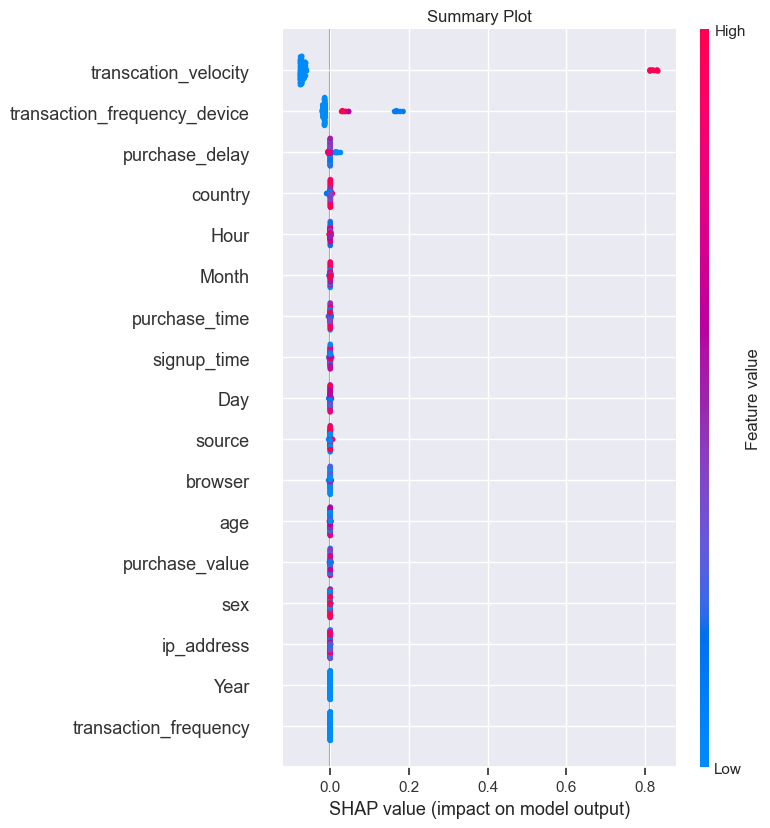

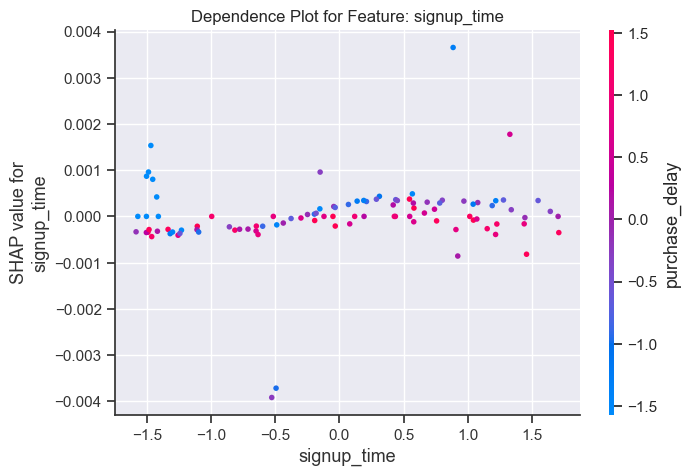

In [19]:
explainer.shap_explanations()

 19/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
d:\KifiyaAIM-Course\Week - 8&9\Adey-Innovations-Fraud-Detection\venv\lib\site-packages\lime\lime_tabular.py:427: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a

<Figure size 1000x600 with 0 Axes>

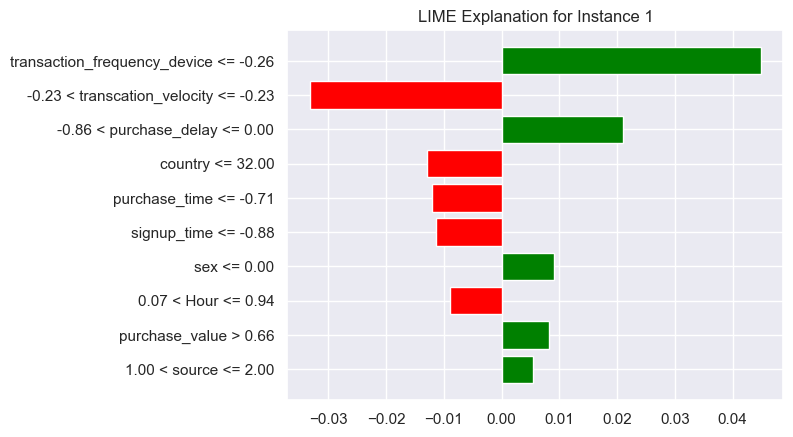

In [21]:
explainer.lime_explanations()